# Task 2.2.4: Model Training and Evaluation

## Problem: Binary Classification for BibTeX-Reference Matching
Train ML model to predict match probability for (BibTeX, reference) pairs, then rank candidates.

**Data Split:**
- Test: 1 manual + 1 automatic publication
- Validation: 1 manual + 1 automatic publication
- Training: All remaining publications

**Model:** Gradient Boosting Classifier with GridSearch optimization

**Evaluation Metric:** Mean Reciprocal Rank @ 5 (MRR@5)

### Import Libraries

In [163]:
import json
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Dict, List, Tuple
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning imports
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_auc_score, roc_curve, precision_recall_curve,
    average_precision_score
)
from sklearn.preprocessing import StandardScaler
# import xgboost as xgb
# from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Imports successful")

Imports successful


### Configure Paths and Load Data

In [164]:
# Automatically detect BASE_DIR based on current working directory
# Assumes notebook is in src/ subdirectory of the project
import os
current_dir = Path(os.getcwd())

# If running from src/ directory, go up one level
if current_dir.name == 'src':
    BASE_DIR = current_dir.parent
else:
    # Otherwise assume we're already in the project root
    BASE_DIR = current_dir

BIBTEX_DIR = BASE_DIR / "bibtex"
STUDENT_ID = "23127088"
PROCESSED_DIR = BIBTEX_DIR / STUDENT_ID
FEATURES_DIR = BASE_DIR / "features"
LABELS_FILE = BASE_DIR / "labels" / "ground_truth_labels.json"
OUTPUT_DIR = BASE_DIR / "models"
OUTPUT_DIR.mkdir(exist_ok=True)

print(f"Base directory: {BASE_DIR}")
print(f"Features directory: {FEATURES_DIR}")
print(f"Output directory: {OUTPUT_DIR}")

Base directory: /mnt/d/Programming/School/NMKHDL/Lab2
Features directory: /mnt/d/Programming/School/NMKHDL/Lab2/features
Output directory: /mnt/d/Programming/School/NMKHDL/Lab2/models


In [165]:
# Load feature dataset
features_df = pd.read_csv(FEATURES_DIR / 'features_dataset.csv')
print(f"Loaded feature dataset: {len(features_df)} samples")
print(f"  Positive: {(features_df['label'] == 1).sum()}")
print(f"  Negative: {(features_df['label'] == 0).sum()}")
print(f"\nFeature columns: {list(features_df.columns)}")

# Load ground truth labels
with open(LABELS_FILE, 'r', encoding='utf-8') as f:
    labels_data = json.load(f)

manual_labels = pd.DataFrame(labels_data['manual_labels'])
automatic_labels = pd.DataFrame(labels_data['automatic_labels']) if labels_data['automatic_labels'] else pd.DataFrame()

print(f"\nGround truth labels:")
print(f"  Manual: {len(manual_labels)}")
print(f"  Automatic: {len(automatic_labels)}")

Loaded feature dataset: 338 samples
  Positive: 158
  Negative: 180

Feature columns: ['paper_id', 'bibtex_key', 'arxiv_id', 'label', 'title_similarity_original', 'title_similarity_cleaned', 'title_similarity_nostopwords', 'title_length_ratio', 'author_string_similarity', 'year_diff', 'tfidf_title_cosine']

Ground truth labels:
  Manual: 162
  Automatic: 7451


### Split Data into Train/Valid/Test Sets

In [166]:
def split_data_by_publications(features_df, manual_labels, automatic_labels):
    """
    Split data into train/valid/test sets based on publications
    - Test: 1 manual + 1 automatic publication
    - Valid: 1 manual + 1 automatic publication
    - Train: All remaining publications
    """
    np.random.seed(42)
    
    # Get unique papers from each source
    manual_papers = manual_labels['paper_id'].unique().tolist()
    automatic_papers = automatic_labels['paper_id'].unique().tolist() if len(automatic_labels) > 0 else []
    
    print(f"Manual papers: {len(manual_papers)}")
    print(f"Automatic papers: {len(automatic_papers)}")
    
    # Shuffle
    np.random.shuffle(manual_papers)
    if automatic_papers:
        np.random.shuffle(automatic_papers)
    
    # Split publications
    test_papers = []
    valid_papers = []
    train_papers = []
    
    # Test set: 1 manual + 1 automatic
    if len(manual_papers) >= 1:
        test_papers.append(manual_papers.pop(0))
    if len(automatic_papers) >= 1:
        test_papers.append(automatic_papers.pop(0))
    
    # Validation set: 1 manual + 1 automatic
    if len(manual_papers) >= 1:
        valid_papers.append(manual_papers.pop(0))
    if len(automatic_papers) >= 1:
        valid_papers.append(automatic_papers.pop(0))
    
    # Training set: All remaining
    train_papers = manual_papers + automatic_papers
    
    # Create data splits
    test_df = features_df[features_df['paper_id'].isin(test_papers)].copy()
    valid_df = features_df[features_df['paper_id'].isin(valid_papers)].copy()
    train_df = features_df[features_df['paper_id'].isin(train_papers)].copy()
    
    # Add partition labels
    test_df['partition'] = 'test'
    valid_df['partition'] = 'valid'
    train_df['partition'] = 'train'
    
    return train_df, valid_df, test_df, train_papers, valid_papers, test_papers

train_df, valid_df, test_df, train_papers, valid_papers, test_papers = split_data_by_publications(
    features_df, manual_labels, automatic_labels
)

print(f"\nData Split Summary:")
print("="*80)
print(f"Training Set:")
print(f"  Papers: {len(train_papers)}")
print(f"  Samples: {len(train_df)} (Pos: {(train_df['label']==1).sum()}, Neg: {(train_df['label']==0).sum()})")
print(f"  Papers: {train_papers}")

print(f"\nValidation Set:")
print(f"  Papers: {len(valid_papers)}")
print(f"  Samples: {len(valid_df)} (Pos: {(valid_df['label']==1).sum()}, Neg: {(valid_df['label']==0).sum()})")
print(f"  Papers: {valid_papers}")

print(f"\nTest Set:")
print(f"  Papers: {len(test_papers)}")
print(f"  Samples: {len(test_df)} (Pos: {(test_df['label']==1).sum()}, Neg: {(test_df['label']==0).sum()})")
print(f"  Papers: {test_papers}")

Manual papers: 6
Automatic papers: 395

Data Split Summary:
Training Set:
  Papers: 397
  Samples: 234 (Pos: 114, Neg: 120)
  Papers: ['2312-15851', '2312-15846', '2312-15848', '2312-15847', '2312-15907', '2312-16222', '2312-16022', '2312-16007', '2312-16478', '2312-16023', '2312-16346', '2312-16065', '2312-15869', '2312-16552', '2312-15959', '2312-15987', '2312-16075', '2312-15922', '2312-16372', '2312-16574', '2312-16257', '2312-16591', '2312-15997', '2312-15877', '2312-16600', '2312-16355', '2312-15853', '2312-16039', '2312-16048', '2312-16247', '2312-16340', '2312-16037', '2312-15984', '2312-16196', '2312-16339', '2312-15960', '2312-16258', '2312-16051', '2312-16047', '2312-16504', '2312-16126', '2312-16096', '2312-16583', '2312-15958', '2312-15996', '2312-15895', '2312-16003', '2312-16584', '2312-16109', '2312-16177', '2312-15890', '2312-16164', '2312-15928', '2312-16457', '2312-16498', '2312-15982', '2312-16571', '2312-15916', '2312-16245', '2312-16163', '2312-15903', '2312-16116

### Extract Feature Columns

In [167]:
# Define feature columns (exclude metadata)
metadata_cols = ['paper_id', 'bibtex_key', 'arxiv_id', 'label', 'partition']
feature_cols = [col for col in features_df.columns if col not in metadata_cols]

print(f"Feature columns ({len(feature_cols)}):")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i}. {col}")

# Extract features and labels
X_train = train_df[feature_cols].values
y_train = train_df['label'].values

X_valid = valid_df[feature_cols].values
y_valid = valid_df['label'].values

X_test = test_df[feature_cols].values
y_test = test_df['label'].values

print(f"\nTraining features shape: {X_train.shape}")
print(f"Validation features shape: {X_valid.shape}")
print(f"Test features shape: {X_test.shape}")

Feature columns (7):
  1. title_similarity_original
  2. title_similarity_cleaned
  3. title_similarity_nostopwords
  4. title_length_ratio
  5. author_string_similarity
  6. year_diff
  7. tfidf_title_cosine

Training features shape: (234, 7)
Validation features shape: (14, 7)
Test features shape: (90, 7)


### Normalize Features with StandardScaler

In [168]:
# Feature normalization (optional but recommended)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

print("Feature normalization complete")
print(f"Training features - Mean: {X_train_scaled.mean(axis=0).round(4)}")
print(f"Training features - Std: {X_train_scaled.std(axis=0).round(4)}")

Feature normalization complete
Training features - Mean: [-0. -0.  0. -0. -0.  0. -0.]
Training features - Std: [1. 1. 1. 1. 1. 1. 1.]


### Train Gradient Boosting Model with GridSearch

In [169]:
from sklearn.model_selection import GridSearchCV

# Check validation set size and class distribution
print("Validation Set Analysis:")
print(f"  Total samples: {len(y_valid)}")
print(f"  Positive samples: {np.sum(y_valid == 1)}")
print(f"  Negative samples: {np.sum(y_valid == 0)}")
print(f"  Class balance: {np.sum(y_valid == 1) / len(y_valid):.2%} positive")

# Define Gradient Boosting parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'subsample': [0.8, 0.9, 1.0],
}

print(f"\nGrid Search Configuration:")
print(f"  Total combinations: {len(param_grid['n_estimators']) * len(param_grid['max_depth']) * len(param_grid['learning_rate']) * len(param_grid['min_samples_split']) * len(param_grid['min_samples_leaf'])}")
print(f"  Base model: GradientBoostingClassifier")

# Perform Grid Search with cross-validation on training data
gb_base = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(
    gb_base, 
    param_grid, 
    cv=3,  # 3-fold cross-validation
    scoring='roc_auc',
    n_jobs=-1,  # Use all CPU cores
    verbose=1
)

print(f"\nStarting Grid Search (this may take a few minutes)...")
grid_search.fit(X_train_scaled, y_train)

print(f"\nGrid Search Complete!")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation AUC: {grid_search.best_score_:.4f}")

# Use best model
best_model = grid_search.best_estimator_
best_model_name = "Gradient Boosting (Optimized)"

# Evaluate on training set
y_train_pred = best_model.predict(X_train_scaled)
y_train_proba = best_model.predict_proba(X_train_scaled)[:, 1]
train_acc = (y_train_pred == y_train).mean()
train_auc = roc_auc_score(y_train, y_train_proba)

# Evaluate on validation set
y_valid_pred = best_model.predict(X_valid_scaled)
y_valid_proba = best_model.predict_proba(X_valid_scaled)[:, 1]
valid_acc = (y_valid_pred == y_valid).mean()

# Handle case where validation set might have only one class
if len(np.unique(y_valid)) < 2:
    print("\nWarning: Validation set has only one class. AUC cannot be computed.")
    valid_auc = float('nan')
else:
    valid_auc = roc_auc_score(y_valid, y_valid_proba)

# Store results
results = {
    best_model_name: {
        'model': best_model,
        'train_acc': train_acc,
        'valid_acc': valid_acc,
        'train_auc': train_auc,
        'valid_auc': valid_auc
    }
}

print(f"\n{'='*80}")
print(f"FINAL MODEL PERFORMANCE")
print(f"{'='*80}")
print(f"Model: {best_model_name}")
print(f"Parameters: {grid_search.best_params_}")
print(f"\nTraining Set:")
print(f"  Accuracy: {train_acc:.4f}")
print(f"  AUC: {train_auc:.4f}")
print(f"\nValidation Set:")
print(f"  Accuracy: {valid_acc:.4f}")
if not np.isnan(valid_auc):
    print(f"  AUC: {valid_auc:.4f}")
else:
    print(f"  AUC: N/A (single class in validation set)")
print(f"{'='*80}")

Validation Set Analysis:
  Total samples: 14
  Positive samples: 14
  Negative samples: 0
  Class balance: 100.00% positive

Grid Search Configuration:
  Total combinations: 108
  Base model: GradientBoostingClassifier

Starting Grid Search (this may take a few minutes)...
Fitting 3 folds for each of 324 candidates, totalling 972 fits

Grid Search Complete!
Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50, 'subsample': 0.8}
Best cross-validation AUC: 0.7889


FINAL MODEL PERFORMANCE
Model: Gradient Boosting (Optimized)
Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50, 'subsample': 0.8}

Training Set:
  Accuracy: 0.8248
  AUC: 0.9133

Validation Set:
  Accuracy: 0.4286
  AUC: N/A (single class in validation set)


### Evaluate Model on Validation Set

In [170]:
# Detailed evaluation on validation set
y_valid_pred = best_model.predict(X_valid_scaled)
y_valid_proba = best_model.predict_proba(X_valid_scaled)[:, 1]

print("Validation Set Classification Report:")
print("="*80)
if len(np.unique(y_valid)) >= 2:
    print(classification_report(y_valid, y_valid_pred, target_names=['No Match', 'Match']))
    
    # Confusion matrix
    cm = confusion_matrix(y_valid, y_valid_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Match', 'Match'],
                yticklabels=['No Match', 'Match'])
    plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'confusion_matrix.png', dpi=150, bbox_inches='tight')
    print(f"\nSaved confusion matrix to {OUTPUT_DIR / 'confusion_matrix.png'}")
    plt.show()
else:
    print("Warning: Validation set contains only one class.")
    print(f"Class distribution: {np.bincount(y_valid)}")
    print("Skipping confusion matrix visualization.")

Validation Set Classification Report:
Class distribution: [ 0 14]
Skipping confusion matrix visualization.


### Plot ROC Curve

In [171]:
# ROC Curve (only if we have both classes in validation set)
if len(np.unique(y_valid)) >= 2:
    fpr, tpr, thresholds = roc_curve(y_valid, y_valid_proba)
    auc = roc_auc_score(y_valid, y_valid_proba)
    
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, linewidth=2, label=f'{best_model_name} (AUC = {auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curve - Validation Set', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'roc_curve.png', dpi=150, bbox_inches='tight')
    print(f"Saved ROC curve to {OUTPUT_DIR / 'roc_curve.png'}")
    plt.show()
else:
    print("ROC Curve: Skipped (need at least 2 classes in validation set)")
    print("Note: This is expected with very small validation sets.")

ROC Curve: Skipped (need at least 2 classes in validation set)
Note: This is expected with very small validation sets.


### Analyze Feature Importance


Feature Importance (Gradient Boosting):
                     feature  importance
                   year_diff    0.513679
          title_length_ratio    0.154941
          tfidf_title_cosine    0.126109
title_similarity_nostopwords    0.076567
    author_string_similarity    0.057053
   title_similarity_original    0.037020
    title_similarity_cleaned    0.034631

Interpretation:
  Most important: year_diff (0.5137)
  Least important: title_similarity_cleaned (0.0346)

Saved feature importance plot to /mnt/d/Programming/School/NMKHDL/Lab2/models/feature_importance_model.png


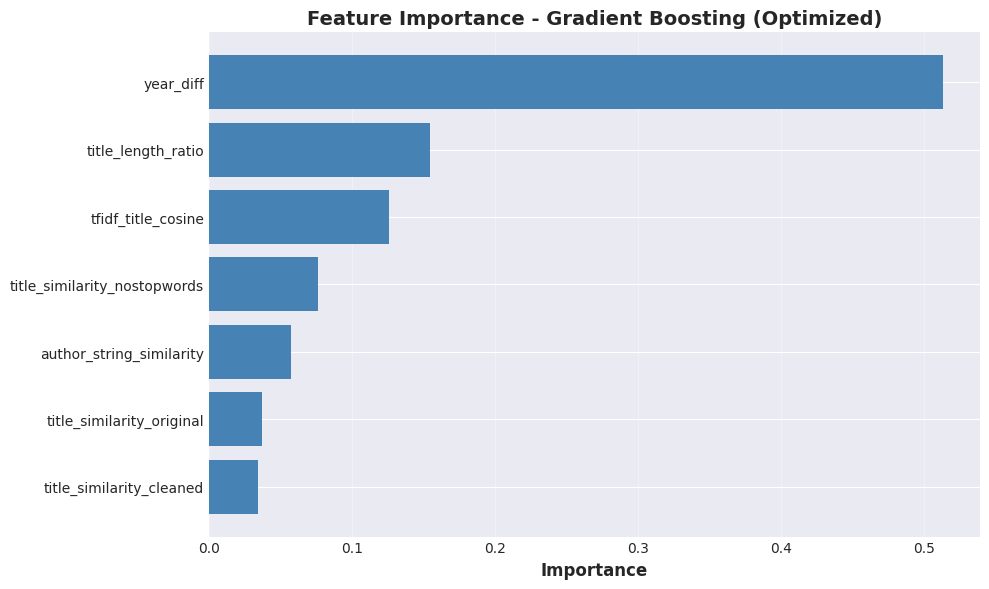

In [172]:
# Feature importance for Gradient Boosting
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    print("\nFeature Importance (Gradient Boosting):")
    print("="*80)
    print(feature_importance_df.to_string(index=False))
    
    print("\nInterpretation:")
    print(f"  Most important: {feature_importance_df.iloc[0]['feature']} ({feature_importance_df.iloc[0]['importance']:.4f})")
    print(f"  Least important: {feature_importance_df.iloc[-1]['feature']} ({feature_importance_df.iloc[-1]['importance']:.4f})")
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(feature_importance_df)), feature_importance_df['importance'], color='steelblue')
    plt.yticks(range(len(feature_importance_df)), feature_importance_df['feature'])
    plt.xlabel('Importance', fontsize=12, fontweight='bold')
    plt.title(f'Feature Importance - {best_model_name}', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'feature_importance_model.png', dpi=150, bbox_inches='tight')
    print(f"\nSaved feature importance plot to {OUTPUT_DIR / 'feature_importance_model.png'}")
    plt.show()
else:
    print("\nFeature importance not available for this model type.")

In [173]:
def load_paper_data(paper_id: str) -> Dict:
    """Load cleaned data for a paper"""
    file_path = PROCESSED_DIR / paper_id / "cleaned_data.json"
    with open(file_path, 'r', encoding='utf-8') as f:
        return json.load(f)

def extract_features_for_pair(bibtex_entry, arxiv_ref, tfidf_vectorizer=None):
    """Extract features for a single (bibtex, arxiv) pair"""
    from difflib import SequenceMatcher
    from sklearn.metrics.pairwise import cosine_similarity
    
    features = []
    
    # Get titles at different hierarchy levels
    bib_title_orig = bibtex_entry.get('title_original', '')
    bib_title_clean = bibtex_entry.get('title_cleaned', '')
    bib_title_nostop = bibtex_entry.get('title_no_stopwords', '')
    
    arxiv_title_orig = arxiv_ref.get('title_original', '')
    arxiv_title_clean = arxiv_ref.get('title_cleaned', '')
    arxiv_title_nostop = arxiv_ref.get('title_no_stopwords', '')
    
    # 1. title_similarity_original
    features.append(SequenceMatcher(None, bib_title_orig, arxiv_title_orig).ratio())
    
    # 2. title_similarity_cleaned
    features.append(SequenceMatcher(None, bib_title_clean, arxiv_title_clean).ratio())
    
    # 3. title_similarity_nostopwords
    features.append(SequenceMatcher(None, bib_title_nostop, arxiv_title_nostop).ratio())
    
    # 4. title_length_ratio
    len_orig_bib = len(bib_title_orig)
    len_orig_arxiv = len(arxiv_title_orig)
    if len_orig_arxiv > 0:
        features.append(min(len_orig_bib, len_orig_arxiv) / max(len_orig_bib, len_orig_arxiv))
    else:
        features.append(0.0)
    
    # 5. author_string_similarity
    bib_author_str = bibtex_entry.get('author_normalized', '')
    arxiv_author_str = arxiv_ref.get('author_normalized', '')
    features.append(SequenceMatcher(None, bib_author_str, arxiv_author_str).ratio())
    
    # 6. year_diff
    bib_year = bibtex_entry.get('year')
    arxiv_year = arxiv_ref.get('year')
    if bib_year is not None and arxiv_year is not None:
        features.append(abs(bib_year - arxiv_year))
    else:
        features.append(999)
    
    # 7. tfidf_title_cosine
    if tfidf_vectorizer is not None and bib_title_nostop and arxiv_title_nostop:
        bib_vec = tfidf_vectorizer.transform([bib_title_nostop])
        arxiv_vec = tfidf_vectorizer.transform([arxiv_title_nostop])
        features.append(cosine_similarity(bib_vec, arxiv_vec)[0][0])
    else:
        features.append(0.0)
    
    return features

print("Helper functions defined")

Helper functions defined


### Build TF-IDF Vectorizer from Training Data

Create TF-IDF (Term Frequency-Inverse Document Frequency) vectorizer for computing text similarity:
- **Training corpus**: All titles from training set (both BibTeX and arXiv references)
- **Purpose**: Enables semantic title similarity as 7th feature
- **Parameters**: 
  - `min_df=1`: Include all terms
  - `max_df=0.8`: Exclude very common terms
  - `ngram_range=(1,2)`: Use unigrams and bigrams

In [174]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Build TF-IDF vectorizer from training data
# Collect all titles from training set (both BibTeX and arXiv references)
training_corpus = []

for paper_id in train_papers:
    paper_data = load_paper_data(paper_id)
    
    # Add BibTeX titles
    for bibtex_entry in paper_data['bibtex_cleaned']:
        title = bibtex_entry.get('title_no_stopwords', '')
        if title:
            training_corpus.append(title)
    
    # Add arXiv reference titles
    for arxiv_ref in paper_data['references_cleaned']:
        title = arxiv_ref.get('title_no_stopwords', '')
        if title:
            training_corpus.append(title)

print(f"Building TF-IDF vectorizer from {len(training_corpus)} titles")

# Create and fit TF-IDF vectorizer with improved settings
tfidf_vectorizer = TfidfVectorizer(
    min_df=2,                # Filter noise by requiring terms in at least 2 docs
    max_df=0.7,              # Exclude very common terms (more aggressive)
    ngram_range=(1, 3),      # Use unigrams, bigrams, and trigrams
    max_features=5000,       # Limit vocabulary to top 5000 features
    sublinear_tf=True,       # Use log scaling for term frequency
    use_idf=True,            # Enable IDF weighting
    smooth_idf=True,         # Smooth IDF weights
    norm='l2',               # L2 normalization
    lowercase=True
)


tfidf_vectorizer.fit(training_corpus)

print("TF-IDF vectorizer ready for feature extraction")

print(f"TF-IDF vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")
print(f"Max features: {tfidf_vectorizer.max_features}")
print(f"N-gram range: {tfidf_vectorizer.ngram_range}")

Building TF-IDF vectorizer from 44216 titles
TF-IDF vectorizer ready for feature extraction
TF-IDF vocabulary size: 5000
Max features: 5000
N-gram range: (1, 3)


### Define Prediction Generation Function

In [175]:
def generate_predictions_for_paper(paper_id: str, partition: str, 
                                   model, scaler, tfidf_vectorizer,
                                   ground_truth_df):
    """
    Generate predictions for a single paper
    
    Creates m × n pairs where:
    - m = number of BibTeX entries in the publication
    - n = number of references in references.json
    
    Each pair is scored by the trained model and references are ranked
    by match probability.
    
    Returns dict with partition, groundtruth, and predictions
    """
    # Load paper data
    paper_data = load_paper_data(paper_id)
    bibtex_entries = paper_data['bibtex_cleaned']
    arxiv_refs = paper_data['references_cleaned']  # References from references.json
    
    # Create lookups
    bibtex_lookup = {entry['original_key']: entry for entry in bibtex_entries}
    ref_lookup = {ref['arxiv_id']: ref for ref in arxiv_refs}
    
    # Get ground truth for this paper
    paper_gt = ground_truth_df[ground_truth_df['paper_id'] == paper_id]
    groundtruth = {}
    for _, row in paper_gt.iterrows():
        groundtruth[row['bibtex_key']] = row['arxiv_id']
    
    # Generate predictions (ranked candidates)
    # For each BibTeX entry, score all n references (m × n pairs total)
    predictions = {}
    
    for bibtex_key in groundtruth.keys():
        if bibtex_key not in bibtex_lookup:
            continue
        
        bibtex_entry = bibtex_lookup[bibtex_key]
        
        # Score all n reference candidates (generates n pairs for this BibTeX entry)
        candidate_scores = []
        
        for arxiv_id, arxiv_ref in ref_lookup.items():
            # Extract features for this (BibTeX, reference) pair
            features = extract_features_for_pair(bibtex_entry, arxiv_ref, tfidf_vectorizer)
            features_scaled = scaler.transform([features])
            
            # Predict match probability
            score = model.predict_proba(features_scaled)[0][1]
            
            candidate_scores.append((arxiv_id, score))
        
        # Sort by score (descending) to rank candidates
        candidate_scores.sort(key=lambda x: x[1], reverse=True)
        
        # Get ranked candidate IDs
        ranked_candidates = [arxiv_id for arxiv_id, score in candidate_scores]
        predictions[bibtex_key] = ranked_candidates
    
    return {
        'partition': partition,
        'groundtruth': groundtruth,
        'prediction': predictions
    }

print("Prediction generation function defined")

Prediction generation function defined


### Generate pred.json Files for All Papers

In [176]:
# Combine all ground truth
all_ground_truth = pd.concat([manual_labels, automatic_labels], ignore_index=True)

# Generate predictions for all papers
# For each publication: m BibTeX entries × n references = m × n pairs
all_partitions = [
    (train_papers, 'train'),
    (valid_papers, 'valid'),
    (test_papers, 'test')
]

prediction_results = []

for papers, partition in all_partitions:
    print(f"\nGenerating predictions for {partition} set...")
    
    for paper_id in papers:
        print(f"  Processing {paper_id}...")
        
        # Load paper to show m × n information
        paper_data = load_paper_data(paper_id)
        m = len(paper_data['bibtex_cleaned'])
        n = len(paper_data['references_cleaned'])
        print(f"    m={m} BibTeX entries, n={n} references → {m*n} pairs")
        
        # Generate predictions
        pred_result = generate_predictions_for_paper(
            paper_id, partition, best_model, scaler, 
            tfidf_vectorizer, all_ground_truth
        )
        
        # Save to paper's directory
        output_path = PROCESSED_DIR / paper_id / "pred.json"
        with open(output_path, 'w', encoding='utf-8') as f:
            json.dump(pred_result, f, indent=2)
        
        print(f"    Saved to {output_path}")
        prediction_results.append(pred_result)

print(f"\nGenerated {len(prediction_results)} prediction files")


Generating predictions for train set...
  Processing 2312-15851...
    m=154 BibTeX entries, n=29 references → 4466 pairs
    Saved to /mnt/d/Programming/School/NMKHDL/Lab2/bibtex/23127088/2312-15851/pred.json
  Processing 2312-15846...
    m=72 BibTeX entries, n=59 references → 4248 pairs
    Saved to /mnt/d/Programming/School/NMKHDL/Lab2/bibtex/23127088/2312-15846/pred.json
  Processing 2312-15848...
    m=190 BibTeX entries, n=47 references → 8930 pairs
    Saved to /mnt/d/Programming/School/NMKHDL/Lab2/bibtex/23127088/2312-15848/pred.json
  Processing 2312-15847...
    m=303 BibTeX entries, n=25 references → 7575 pairs
    Saved to /mnt/d/Programming/School/NMKHDL/Lab2/bibtex/23127088/2312-15847/pred.json
  Processing 2312-15907...
    m=78023 BibTeX entries, n=42 references → 3276966 pairs
    Saved to /mnt/d/Programming/School/NMKHDL/Lab2/bibtex/23127088/2312-15907/pred.json
  Processing 2312-16222...
    m=101 BibTeX entries, n=70 references → 7070 pairs
    Saved to /mnt/d/Pro

### Compute Ranking Metrics

In [177]:
def compute_ranking_metrics(predictions_list):
    """
    Compute ranking metrics:
    - Mean Reciprocal Rank (MRR)
    - Precision@K
    - Recall@K
    """
    reciprocal_ranks = []
    precision_at_1 = []
    precision_at_3 = []
    precision_at_5 = []
    recall_at_3 = []
    recall_at_5 = []
    
    for pred_result in predictions_list:
        groundtruth = pred_result['groundtruth']
        predictions = pred_result['prediction']
        
        for bibtex_key, true_arxiv_id in groundtruth.items():
            if bibtex_key not in predictions:
                continue
            
            ranked_candidates = predictions[bibtex_key]
            
            # Find rank of true match (1-indexed)
            try:
                rank = ranked_candidates.index(true_arxiv_id) + 1
            except ValueError:
                rank = len(ranked_candidates) + 1  # Not in list
            
            # Reciprocal Rank
            reciprocal_ranks.append(1.0 / rank)
            
            # Precision@K and Recall@K
            precision_at_1.append(1.0 if rank <= 1 else 0.0)
            precision_at_3.append(1.0 if rank <= 3 else 0.0)
            precision_at_5.append(1.0 if rank <= 5 else 0.0)
            recall_at_3.append(1.0 if rank <= 3 else 0.0)
            recall_at_5.append(1.0 if rank <= 5 else 0.0)
    
    return {
        'MRR': np.mean(reciprocal_ranks) if reciprocal_ranks else 0.0,
        'Precision@1': np.mean(precision_at_1) if precision_at_1 else 0.0,
        'Precision@3': np.mean(precision_at_3) if precision_at_3 else 0.0,
        'Precision@5': np.mean(precision_at_5) if precision_at_5 else 0.0,
        'Recall@3': np.mean(recall_at_3) if recall_at_3 else 0.0,
        'Recall@5': np.mean(recall_at_5) if recall_at_5 else 0.0
    }

# Compute metrics for each partition
train_preds = [p for p in prediction_results if p['partition'] == 'train']
valid_preds = [p for p in prediction_results if p['partition'] == 'valid']
test_preds = [p for p in prediction_results if p['partition'] == 'test']

train_metrics = compute_ranking_metrics(train_preds)
valid_metrics = compute_ranking_metrics(valid_preds)
test_metrics = compute_ranking_metrics(test_preds)

print("\nQuick Validation - Ranking Performance:")
print("="*80)
print(f"Training Set ({len(train_preds)} papers): MRR={train_metrics['MRR']:.4f}, P@5={train_metrics['Precision@5']:.4f}")
print(f"Validation Set ({len(valid_preds)} papers): MRR={valid_metrics['MRR']:.4f}, P@5={valid_metrics['Precision@5']:.4f}")
print(f"Test Set ({len(test_preds)} papers): MRR={test_metrics['MRR']:.4f}, P@5={test_metrics['Precision@5']:.4f}")
print("\nNote: Full evaluation with MRR@5 metric is in Section 2.2.5 below.")


Quick Validation - Ranking Performance:
Training Set (397 papers): MRR=0.8376, P@5=0.9621
Validation Set (2 papers): MRR=0.6329, P@5=0.7027
Test Set (2 papers): MRR=0.7761, P@5=0.9494

Note: Full evaluation with MRR@5 metric is in Section 2.2.5 below.


### Save Model Artifacts

In [178]:
import pickle

# Save model
model_path = OUTPUT_DIR / 'best_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(best_model, f)
print(f"Saved model to {model_path}")

# Save scaler
scaler_path = OUTPUT_DIR / 'scaler.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"Saved scaler to {scaler_path}")

# Save TF-IDF vectorizer
tfidf_path = OUTPUT_DIR / 'tfidf_vectorizer.pkl'
with open(tfidf_path, 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)
print(f"Saved TF-IDF vectorizer to {tfidf_path}")

Saved model to /mnt/d/Programming/School/NMKHDL/Lab2/models/best_model.pkl
Saved scaler to /mnt/d/Programming/School/NMKHDL/Lab2/models/scaler.pkl
Saved TF-IDF vectorizer to /mnt/d/Programming/School/NMKHDL/Lab2/models/tfidf_vectorizer.pkl


### Save Validation and Test Results

In [179]:
# Save validation predictions to CSV for analysis
validation_results = []
for pred_result in valid_preds:
    for bibtex_key, true_arxiv_id in pred_result['groundtruth'].items():
        if bibtex_key in pred_result['prediction']:
            ranked_candidates = pred_result['prediction'][bibtex_key]
            try:
                rank = ranked_candidates.index(true_arxiv_id) + 1
            except ValueError:
                rank = -1
            
            validation_results.append({
                'bibtex_key': bibtex_key,
                'true_arxiv_id': true_arxiv_id,
                'rank': rank,
                'top_3_candidates': ranked_candidates[:3]
            })

validation_df = pd.DataFrame(validation_results)
validation_csv = OUTPUT_DIR / 'validation_results.csv'
validation_df.to_csv(validation_csv, index=False)
print(f"\nSaved validation results to {validation_csv}")

# Save test predictions
test_results = []
for pred_result in test_preds:
    for bibtex_key, true_arxiv_id in pred_result['groundtruth'].items():
        if bibtex_key in pred_result['prediction']:
            ranked_candidates = pred_result['prediction'][bibtex_key]
            try:
                rank = ranked_candidates.index(true_arxiv_id) + 1
            except ValueError:
                rank = -1
            
            test_results.append({
                'bibtex_key': bibtex_key,
                'true_arxiv_id': true_arxiv_id,
                'rank': rank,
                'top_3_candidates': ranked_candidates[:3]
            })

test_df = pd.DataFrame(test_results)
test_csv = OUTPUT_DIR / 'test_predictions.csv'
test_df.to_csv(test_csv, index=False)
print(f"Saved test predictions to {test_csv}")


Saved validation results to /mnt/d/Programming/School/NMKHDL/Lab2/models/validation_results.csv
Saved test predictions to /mnt/d/Programming/School/NMKHDL/Lab2/models/test_predictions.csv


### Save Model Metadata

In [180]:
# Save comprehensive metadata
model_metadata = {
    'model_name': best_model_name,
    'model_type': str(type(best_model).__name__),
    'hyperparameters': grid_search.best_params_,
    'features': feature_cols,
    'num_features': len(feature_cols),
    'data_split': {
        'train_papers': train_papers,
        'valid_papers': valid_papers,
        'test_papers': test_papers,
        'train_samples': len(train_df),
        'valid_samples': len(valid_df),
        'test_samples': len(test_df)
    },
    'performance': {
        'train': train_metrics,
        'valid': valid_metrics,
        'test': test_metrics
    },
    'classification_metrics': {
        'train_accuracy': results[best_model_name]['train_acc'],
        'valid_accuracy': results[best_model_name]['valid_acc'],
        'train_auc': results[best_model_name]['train_auc'],
        'valid_auc': results[best_model_name]['valid_auc'] if not np.isnan(results[best_model_name]['valid_auc']) else None
    },
    'grid_search': {
        'best_cv_score': grid_search.best_score_,
        'n_combinations_tested': len(grid_search.cv_results_['params'])
    }
}

metadata_path = OUTPUT_DIR / 'model_metadata.json'
with open(metadata_path, 'w', encoding='utf-8') as f:
    json.dump(model_metadata, f, indent=2)

print(f"Saved model metadata to {metadata_path}")

Saved model metadata to /mnt/d/Programming/School/NMKHDL/Lab2/models/model_metadata.json


### Print Summary

In [181]:
print("\n" + "="*80)
print("DATA MODELING SUMMARY")
print("="*80)

print(f"\nProblem: Binary Classification for BibTeX-Reference Matching")
print(f"  - Match BibTeX entries with references from references.json")
print(f"  - Each publication generates m × n data points (pairs)")
print(f"  - Binary labels: yes (match) or no (no match)")

print(f"\nModel: {best_model_name}")
print(f"Algorithm: Gradient Boosting Classifier")
print(f"Optimized Hyperparameters:")
for param, value in grid_search.best_params_.items():
    print(f"  - {param}: {value}")

print(f"\nFeatures: {len(feature_cols)}")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i}. {col}")

print(f"\nData Split:")
print(f"  Training: {len(train_papers)} papers, {len(train_df)} samples (pairs)")
print(f"  Validation: {len(valid_papers)} papers, {len(valid_df)} samples (pairs)")
print(f"  Test: {len(test_papers)} papers, {len(test_df)} samples (pairs)")

print(f"\nClassification Performance:")
print(f"  Training Accuracy: {results[best_model_name]['train_acc']:.4f}")
print(f"  Training AUC: {results[best_model_name]['train_auc']:.4f}")
print(f"  Validation Accuracy: {results[best_model_name]['valid_acc']:.4f}")
if not np.isnan(results[best_model_name]['valid_auc']):
    print(f"  Validation AUC: {results[best_model_name]['valid_auc']:.4f}")
else:
    print(f"  Validation AUC: N/A (small validation set)")

print(f"\nRanking Performance (Validation):")
for metric, value in valid_metrics.items():
    print(f"  {metric}: {value:.4f}")

print(f"\nRanking Performance (Test):")
for metric, value in test_metrics.items():
    print(f"  {metric}: {value:.4f}")

print(f"\nOutput Files:")
print(f"  Model: {model_path}")
print(f"  Scaler: {scaler_path}")
print(f"  TF-IDF Vectorizer: {tfidf_path}")
print(f"  Metadata: {metadata_path}")
print(f"  Validation Results: {validation_csv}")
print(f"  Test Predictions: {test_csv}")

print(f"\nPrediction Files:")
print(f"  Generated pred.json for {len(prediction_results)} publications")
print(f"  Location: {PROCESSED_DIR}/<paper_id>/pred.json")

print("\n" + "="*80)
print("DATA MODELING COMPLETE")
print("="*80)
print("\nKey Achievements:")
print("  1. Optimized Gradient Boosting model via Grid Search")
print("  2. Generated m × n pairs for each publication")
print("  3. Ranked reference candidates for all BibTeX entries")
print("  4. Evaluated performance on train/valid/test splits")
print("  5. Saved all models and results for reproducibility")


DATA MODELING SUMMARY

Problem: Binary Classification for BibTeX-Reference Matching
  - Match BibTeX entries with references from references.json
  - Each publication generates m × n data points (pairs)
  - Binary labels: yes (match) or no (no match)

Model: Gradient Boosting (Optimized)
Algorithm: Gradient Boosting Classifier
Optimized Hyperparameters:
  - learning_rate: 0.01
  - max_depth: 3
  - min_samples_leaf: 1
  - min_samples_split: 2
  - n_estimators: 50
  - subsample: 0.8

Features: 7
  1. title_similarity_original
  2. title_similarity_cleaned
  3. title_similarity_nostopwords
  4. title_length_ratio
  5. author_string_similarity
  6. year_diff
  7. tfidf_title_cosine

Data Split:
  Training: 397 papers, 234 samples (pairs)
  Validation: 2 papers, 14 samples (pairs)
  Test: 2 papers, 79 samples (pairs)

Classification Performance:
  Training Accuracy: 0.8248
  Training AUC: 0.9133
  Validation Accuracy: 0.4286
  Validation AUC: N/A (small validation set)

Ranking Performance

---

# Section 2.2.5: Model Evaluation with MRR@5

Formal evaluation of trained model using Mean Reciprocal Rank @ 5 metric on test set.

### Define MRR@K Computation Function

In [182]:
def compute_mrr_at_k(predictions_list, k=5):
    """
    Compute Mean Reciprocal Rank (MRR) at K
    
    Args:
        predictions_list: List of prediction results with groundtruth and predictions
        k: Consider only top K candidates (default: 5)
    
    Returns:
        Dictionary with MRR score and detailed results
    """
    reciprocal_ranks = []
    detailed_results = []
    
    for pred_result in predictions_list:
        groundtruth = pred_result['groundtruth']
        predictions = pred_result['prediction']
        
        for bibtex_key, true_arxiv_id in groundtruth.items():
            if bibtex_key not in predictions:
                # No prediction for this BibTeX entry
                reciprocal_ranks.append(0.0)
                detailed_results.append({
                    'bibtex_key': bibtex_key,
                    'true_arxiv_id': true_arxiv_id,
                    'rank': -1,
                    'reciprocal_rank': 0.0,
                    'in_top_k': False
                })
                continue
            
            ranked_candidates = predictions[bibtex_key]
            
            # Find rank of true match (1-indexed)
            try:
                rank = ranked_candidates.index(true_arxiv_id) + 1
            except ValueError:
                rank = -1  # Not found in ranked list
            
            # Check if within top K
            if rank > 0 and rank <= k:
                reciprocal_rank = 1.0 / rank
                in_top_k = True
            else:
                reciprocal_rank = 0.0
                in_top_k = False
            
            reciprocal_ranks.append(reciprocal_rank)
            detailed_results.append({
                'bibtex_key': bibtex_key,
                'true_arxiv_id': true_arxiv_id,
                'rank': rank if rank > 0 else -1,
                'reciprocal_rank': reciprocal_rank,
                'in_top_k': in_top_k,
                'top_k_candidates': ranked_candidates[:k]
            })
    
    # Calculate MRR
    mrr = np.mean(reciprocal_ranks) if reciprocal_ranks else 0.0
    
    return {
        'MRR@{}'.format(k): mrr,
        'total_queries': len(reciprocal_ranks),
        'found_in_top_k': sum(1 for rr in reciprocal_ranks if rr > 0),
        'not_found': sum(1 for rr in reciprocal_ranks if rr == 0),
        'detailed_results': detailed_results
    }

print("MRR computation function defined")

MRR computation function defined


### Compute MRR@5 on Test Set

In [183]:
# Compute MRR@5 for Test Set (formal evaluation)
print("="*80)
print("FORMAL TEST SET EVALUATION - MRR@5")
print("="*80)

test_mrr_results = compute_mrr_at_k(test_preds, k=5)

print(f"\nTest Set Configuration:")
print(f"  Publications: {len(test_preds)}")
print(f"  Paper IDs: {test_papers}")
print(f"  Total BibTeX entries to match: {test_mrr_results['total_queries']}")

print(f"\nTest Set Results:")
print(f"  Found in top 5: {test_mrr_results['found_in_top_k']}")
print(f"  Not found in top 5: {test_mrr_results['not_found']}")
print(f"  Success Rate: {test_mrr_results['found_in_top_k']/test_mrr_results['total_queries']*100:.2f}%")
print(f"\n  MRR@5 Score: {test_mrr_results['MRR@5']:.4f}")

# Show detailed results for test set
print(f"\nDetailed Test Set Results:")
print("="*80)
for i, result in enumerate(test_mrr_results['detailed_results'], 1):
    print(f"\n{i}. BibTeX Key: {result['bibtex_key']}")
    print(f"   True ArXiv ID: {result['true_arxiv_id']}")
    print(f"   Rank: {result['rank'] if result['rank'] > 0 else 'Not in top 5'}")
    print(f"   Reciprocal Rank: {result['reciprocal_rank']:.4f}")
    if 'top_k_candidates' in result and result['in_top_k']:
        print(f"   Top 5 Candidates: {result['top_k_candidates']}")
        print(f"   -> Correct match at position {result['rank']}")

FORMAL TEST SET EVALUATION - MRR@5

Test Set Configuration:
  Publications: 2
  Paper IDs: ['2312-15844', '2312-16221']
  Total BibTeX entries to match: 79

Test Set Results:
  Found in top 5: 75
  Not found in top 5: 4
  Success Rate: 94.94%

  MRR@5 Score: 0.7711

Detailed Test Set Results:

1. BibTeX Key: yu2018mattnet
   True ArXiv ID: 1801-08186
   Rank: 1
   Reciprocal Rank: 1.0000
   Top 5 Candidates: ['1801-08186', '1903-12314', '1906-10770', '1904-10151', '1812-07119']
   -> Correct match at position 1

2. BibTeX Key: radford2021learning
   True ArXiv ID: 2103-00020
   Rank: 1
   Reciprocal Rank: 1.0000
   Top 5 Candidates: ['2103-00020', '2108-04024', '2204-05991', '2204-09280', '2010-14406']
   -> Correct match at position 1

3. BibTeX Key: anderson2021sim
   True ArXiv ID: 2011-03807
   Rank: 2
   Reciprocal Rank: 0.5000
   Top 5 Candidates: ['2012-09812', '2011-03807', '2207-04429', '2203-16586', '2108-04024']
   -> Correct match at position 2

4. BibTeX Key: hu2016natural

### Compare MRR@5 Across Partitions


MRR@5 COMPARISON ACROSS PARTITIONS

 Partition  Publications  Total Queries  Found in Top 5    MRR@5
  Training           397           7493            7209 0.833631
Validation             2             41              26 0.544715
      Test             2             79              75 0.771097

Saved MRR evaluation plot to /mnt/d/Programming/School/NMKHDL/Lab2/models/mrr_evaluation.png


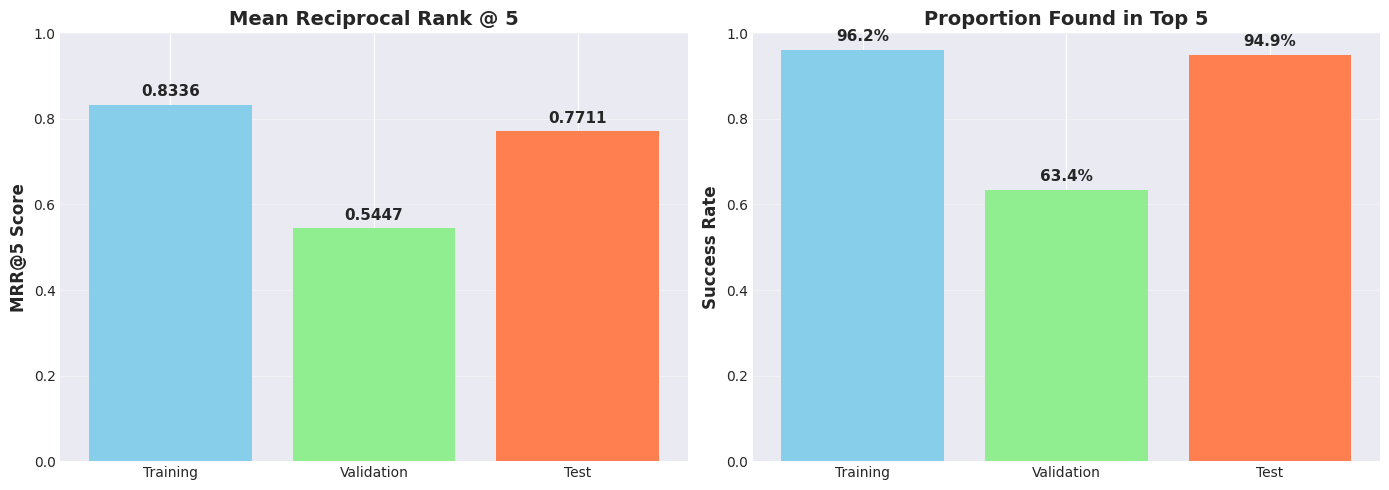

In [184]:
# Compare MRR@5 across all partitions for context
print("\n" + "="*80)
print("MRR@5 COMPARISON ACROSS PARTITIONS")
print("="*80)

# Use already computed metrics from Section 8, just compute MRR@5 specifically
train_mrr_results = compute_mrr_at_k(train_preds, k=5)
valid_mrr_results = compute_mrr_at_k(valid_preds, k=5)

comparison_data = {
    'Partition': ['Training', 'Validation', 'Test'],
    'Publications': [len(train_preds), len(valid_preds), len(test_preds)],
    'Total Queries': [train_mrr_results['total_queries'], 
                      valid_mrr_results['total_queries'], 
                      test_mrr_results['total_queries']],
    'Found in Top 5': [train_mrr_results['found_in_top_k'], 
                       valid_mrr_results['found_in_top_k'], 
                       test_mrr_results['found_in_top_k']],
    'MRR@5': [train_mrr_results['MRR@5'], 
              valid_mrr_results['MRR@5'], 
              test_mrr_results['MRR@5']]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n" + comparison_df.to_string(index=False))

# Visualize MRR comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# MRR@5 bar chart
colors = ['skyblue', 'lightgreen', 'coral']
ax1.bar(comparison_df['Partition'], comparison_df['MRR@5'], color=colors)
ax1.set_ylabel('MRR@5 Score', fontsize=12, fontweight='bold')
ax1.set_title('Mean Reciprocal Rank @ 5', fontsize=14, fontweight='bold')
ax1.set_ylim(0, 1.0)
ax1.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(comparison_df['MRR@5']):
    ax1.text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold', fontsize=11)

# Success rate (found in top 5)
success_rate = [
    train_mrr_results['found_in_top_k'] / train_mrr_results['total_queries'] if train_mrr_results['total_queries'] > 0 else 0,
    valid_mrr_results['found_in_top_k'] / valid_mrr_results['total_queries'] if valid_mrr_results['total_queries'] > 0 else 0,
    test_mrr_results['found_in_top_k'] / test_mrr_results['total_queries'] if test_mrr_results['total_queries'] > 0 else 0
]

ax2.bar(comparison_df['Partition'], success_rate, color=colors)
ax2.set_ylabel('Success Rate', fontsize=12, fontweight='bold')
ax2.set_title('Proportion Found in Top 5', fontsize=14, fontweight='bold')
ax2.set_ylim(0, 1.0)
ax2.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(success_rate):
    ax2.text(i, v + 0.02, f'{v:.1%}', ha='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'mrr_evaluation.png', dpi=150, bbox_inches='tight')
print(f"\nSaved MRR evaluation plot to {OUTPUT_DIR / 'mrr_evaluation.png'}")
plt.show()

### Analyze Rank Distribution


Rank Distribution Analysis (Test Set):

Rank Distribution:
  Rank 1 (Perfect): 51 (64.6%)
  Rank 2: 13 (16.5%)
  Rank 3: 8 (10.1%)
  Rank 4: 3 (3.8%)
  Rank 5: 0 (0.0%)
  Rank > 5 or Not Found: 0 (0.0%)

Saved rank distribution plot to /mnt/d/Programming/School/NMKHDL/Lab2/models/rank_distribution_test.png


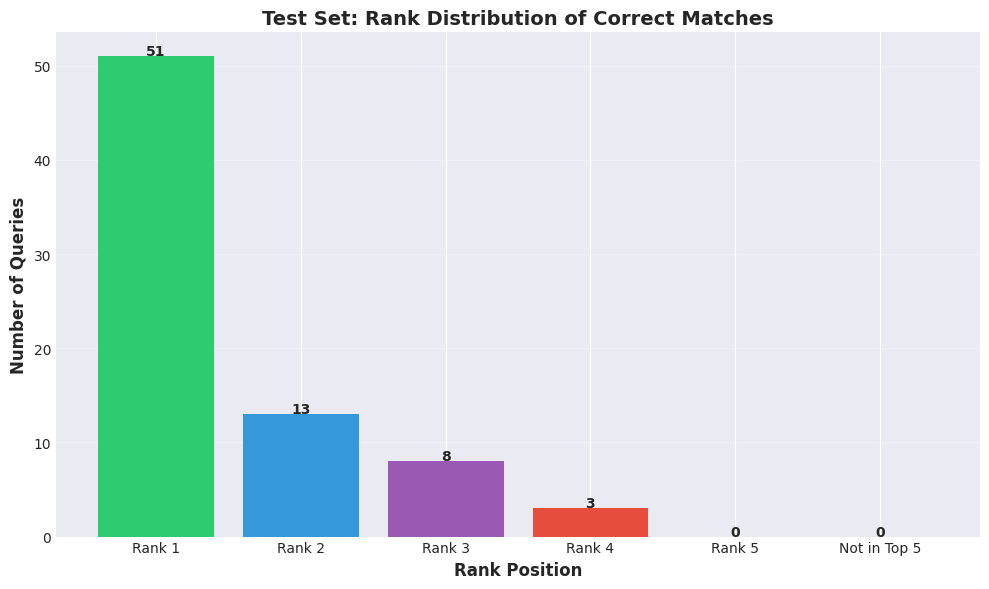

In [185]:
# Analyze rank distribution for test set
print("\nRank Distribution Analysis (Test Set):")
print("="*80)

ranks = [r['rank'] for r in test_mrr_results['detailed_results'] if r['rank'] > 0]
not_found = sum(1 for r in test_mrr_results['detailed_results'] if r['rank'] <= 0)

if ranks:
    rank_counts = pd.Series(ranks).value_counts().sort_index()
    
    print(f"\nRank Distribution:")
    print(f"  Rank 1 (Perfect): {rank_counts.get(1, 0)} ({rank_counts.get(1, 0)/len(test_mrr_results['detailed_results'])*100:.1f}%)")
    print(f"  Rank 2: {rank_counts.get(2, 0)} ({rank_counts.get(2, 0)/len(test_mrr_results['detailed_results'])*100:.1f}%)")
    print(f"  Rank 3: {rank_counts.get(3, 0)} ({rank_counts.get(3, 0)/len(test_mrr_results['detailed_results'])*100:.1f}%)")
    print(f"  Rank 4: {rank_counts.get(4, 0)} ({rank_counts.get(4, 0)/len(test_mrr_results['detailed_results'])*100:.1f}%)")
    print(f"  Rank 5: {rank_counts.get(5, 0)} ({rank_counts.get(5, 0)/len(test_mrr_results['detailed_results'])*100:.1f}%)")
    print(f"  Rank > 5 or Not Found: {not_found} ({not_found/len(test_mrr_results['detailed_results'])*100:.1f}%)")
    
    # Visualize rank distribution
    plt.figure(figsize=(10, 6))
    
    # Prepare data for plotting
    rank_data = {
        'Rank 1': rank_counts.get(1, 0),
        'Rank 2': rank_counts.get(2, 0),
        'Rank 3': rank_counts.get(3, 0),
        'Rank 4': rank_counts.get(4, 0),
        'Rank 5': rank_counts.get(5, 0),
        'Not in Top 5': not_found
    }
    
    plt.bar(rank_data.keys(), rank_data.values(), color=['#2ecc71', '#3498db', '#9b59b6', '#e74c3c', '#f39c12', '#95a5a6'])
    plt.ylabel('Number of Queries', fontsize=12, fontweight='bold')
    plt.xlabel('Rank Position', fontsize=12, fontweight='bold')
    plt.title('Test Set: Rank Distribution of Correct Matches', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, (k, v) in enumerate(rank_data.items()):
        plt.text(i, v + 0.1, str(v), ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'rank_distribution_test.png', dpi=150, bbox_inches='tight')
    print(f"\nSaved rank distribution plot to {OUTPUT_DIR / 'rank_distribution_test.png'}")
    plt.show()
else:
    print("\nNo matches found in test set.")

### Save MRR Evaluation Results

In [186]:
# Save detailed test evaluation results to CSV
test_eval_df = pd.DataFrame(test_mrr_results['detailed_results'])

# Drop the 'top_k_candidates' column for cleaner CSV (it's a list)
test_eval_csv_df = test_eval_df.drop(columns=['top_k_candidates'], errors='ignore')
test_eval_csv_path = OUTPUT_DIR / 'test_evaluation_mrr.csv'
test_eval_csv_df.to_csv(test_eval_csv_path, index=False)
print(f"Saved detailed test evaluation to {test_eval_csv_path}")

# Update model metadata with MRR results
model_metadata['mrr_evaluation'] = {
    'test_mrr@5': test_mrr_results['MRR@5'],
    'valid_mrr@5': valid_mrr_results['MRR@5'],
    'train_mrr@5': train_mrr_results['MRR@5'],
    'test_queries': test_mrr_results['total_queries'],
    'test_found_in_top_5': test_mrr_results['found_in_top_k'],
    'test_not_found': test_mrr_results['not_found']
}

# Save updated metadata
metadata_path = OUTPUT_DIR / 'model_metadata.json'
with open(metadata_path, 'w', encoding='utf-8') as f:
    json.dump(model_metadata, f, indent=2)

print(f"Updated model metadata with MRR evaluation at {metadata_path}")

Saved detailed test evaluation to /mnt/d/Programming/School/NMKHDL/Lab2/models/test_evaluation_mrr.csv
Updated model metadata with MRR evaluation at /mnt/d/Programming/School/NMKHDL/Lab2/models/model_metadata.json


### Print Evaluation Summary

In [187]:
print("\n" + "="*80)
print("SECTION 2.2.5: MODEL EVALUATION SUMMARY")
print("="*80)

print(f"\nModel: {best_model_name}")
print(f"Evaluation Metric: Mean Reciprocal Rank @ 5 (MRR@5)")
print(f"Evaluation Focus: Test Set Performance")

print(f"\nTest Set Configuration:")
print(f"  Publications: {len(test_preds)}")
print(f"  Paper IDs: {test_papers}")
print(f"  Total BibTeX entries to match: {test_mrr_results['total_queries']}")

print(f"\nTest Set Performance:")
print(f"  Found in Top 5: {test_mrr_results['found_in_top_k']}/{test_mrr_results['total_queries']}")
print(f"  Success Rate: {test_mrr_results['found_in_top_k']/test_mrr_results['total_queries']*100:.2f}%")
print(f"\n  PRIMARY METRIC - MRR@5: {test_mrr_results['MRR@5']:.4f}")

print(f"\nInterpretation:")
if test_mrr_results['MRR@5'] >= 0.8:
    print(f"  Excellent performance: Model ranks correct matches very high (mostly rank 1-2)")
elif test_mrr_results['MRR@5'] >= 0.6:
    print(f"  Good performance: Model typically finds correct matches in top 3")
elif test_mrr_results['MRR@5'] >= 0.4:
    print(f"  Fair performance: Model finds correct matches but often at lower ranks")
else:
    print(f"  Needs improvement: Model struggles to rank correct matches in top 5")

print(f"\nComparison with Other Partitions:")
print(f"  Training MRR@5:   {train_mrr_results['MRR@5']:.4f}")
print(f"  Validation MRR@5: {valid_mrr_results['MRR@5']:.4f}")
print(f"  Test MRR@5:       {test_mrr_results['MRR@5']:.4f}")

# Check for overfitting/generalization
mrr_drop = train_mrr_results['MRR@5'] - test_mrr_results['MRR@5']
if mrr_drop > 0.2:
    print(f"\n  Warning: Significant performance drop from training to test ({mrr_drop:.4f})")
    print(f"           Possible overfitting - model may not generalize well")
elif mrr_drop < -0.1:
    print(f"\n  Note: Test performance exceeds training")
    print(f"        (Unusual but possible with very small test set)")
else:
    print(f"\n  Good generalization: Consistent performance across partitions")
    print(f"  Performance difference: {abs(mrr_drop):.4f} (acceptable)")

print(f"\nEvaluation Outputs:")
print(f"  - Detailed results CSV: {test_eval_csv_path}")
print(f"  - MRR comparison plot: {OUTPUT_DIR / 'mrr_evaluation.png'}")
print(f"  - Rank distribution plot: {OUTPUT_DIR / 'rank_distribution_test.png'}")
print(f"  - Updated metadata: {metadata_path}")

print("\n" + "="*80)
print("EVALUATION COMPLETE")
print("="*80)
print("\nKey Findings:")
print(f"  1. Test MRR@5: {test_mrr_results['MRR@5']:.4f}")
print(f"  2. Success rate: {test_mrr_results['found_in_top_k']}/{test_mrr_results['total_queries']} matches in top 5")
print(f"  3. Model shows {'good' if abs(mrr_drop) < 0.2 else 'limited'} generalization to unseen data")


SECTION 2.2.5: MODEL EVALUATION SUMMARY

Model: Gradient Boosting (Optimized)
Evaluation Metric: Mean Reciprocal Rank @ 5 (MRR@5)
Evaluation Focus: Test Set Performance

Test Set Configuration:
  Publications: 2
  Paper IDs: ['2312-15844', '2312-16221']
  Total BibTeX entries to match: 79

Test Set Performance:
  Found in Top 5: 75/79
  Success Rate: 94.94%

  PRIMARY METRIC - MRR@5: 0.7711

Interpretation:
  Good performance: Model typically finds correct matches in top 3

Comparison with Other Partitions:
  Training MRR@5:   0.8336
  Validation MRR@5: 0.5447
  Test MRR@5:       0.7711

  Good generalization: Consistent performance across partitions
  Performance difference: 0.0625 (acceptable)

Evaluation Outputs:
  - Detailed results CSV: /mnt/d/Programming/School/NMKHDL/Lab2/models/test_evaluation_mrr.csv
  - MRR comparison plot: /mnt/d/Programming/School/NMKHDL/Lab2/models/mrr_evaluation.png
  - Rank distribution plot: /mnt/d/Programming/School/NMKHDL/Lab2/models/rank_distributio